# 🔺 Construcción de la Triangulación Causal
Este notebook toma un árbol de Galton-Watson con espina y genera la triangulación causal correspondiente en el cilindro \( S \times [n, n+1] \).

--- Tree Generation Output ---
Seed used for generation: 44845

Number of nodes per level:
Level 0: 1 nodes
Level 1: 2 nodes
Level 2: 7 nodes
Level 3: 12 nodes
Level 4: 10 nodes
Level 5: 7 nodes
Level 6: 23 nodes
Level 7: 21 nodes
--------------------------
Generando gráfica 2D corregida...


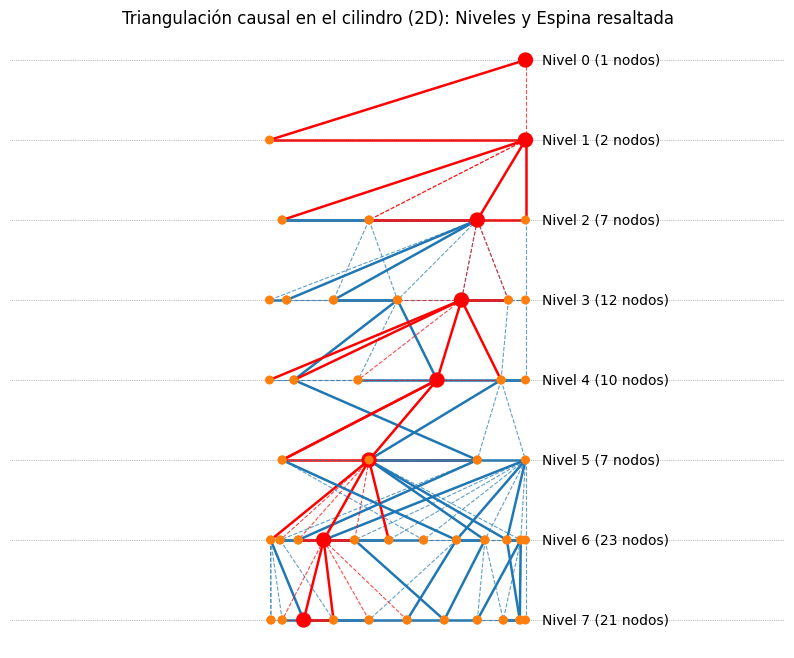

Generando gráfica 3D básica...


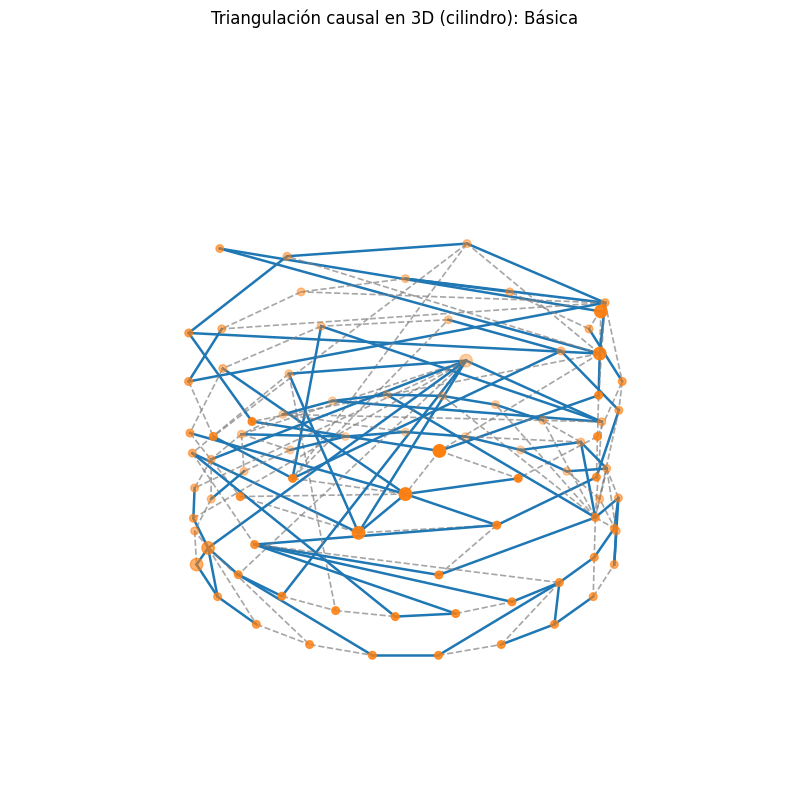

Generando gráfica 3D corregida...


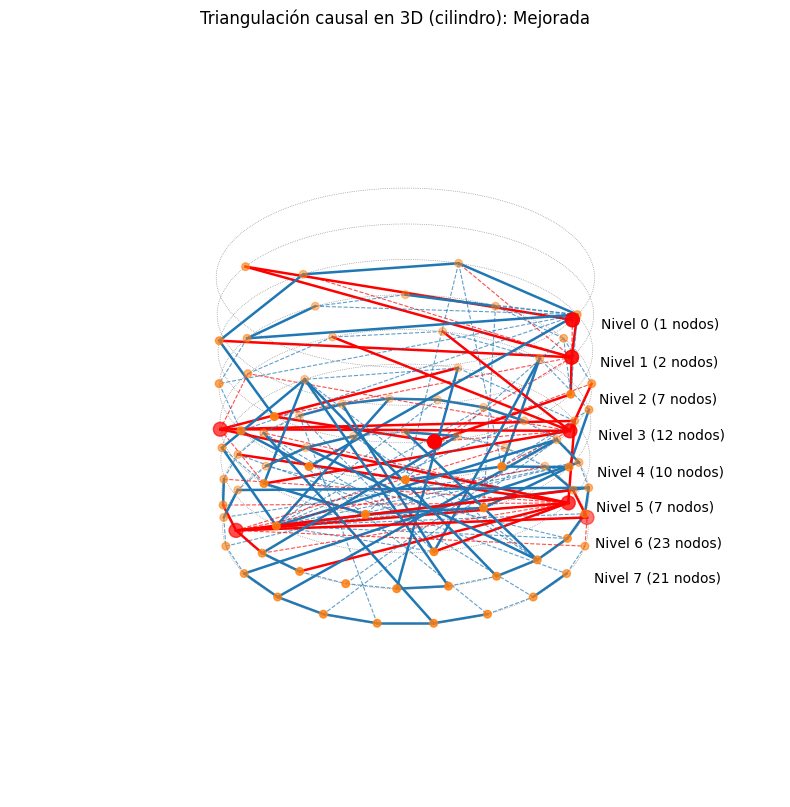

Generación de gráficos completada.


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from mpl_toolkits.mplot3d import Axes3D # Explicitly import Axes3D for clarity

# =========================================================
# 1) Muestreos: pk (geométrica base) y rho (sesgada por tamaño)
# =========================================================

def sample_pk(rng):
    """
    pk = 1 / 2^(k+1), k >= 0  (geométrica en 'fracasos antes del primer éxito' con p=1/2)
    NumPy: Geometric(p) retorna {1,2,...}; restamos 1 para obtener {0,1,2,...}
    """
    return rng.geometric(0.5) - 1

def sample_rho(rng):
    """
    rho_k = k / 2^(k+1), k >= 1
    Muestreo por inversa de la CDF cerrada: F(n) = 1 - (n+2) / (2 ** (n + 1))
    """
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

# =========================================================
# 2) Generación de capas (niveles) con registro exacto de hijos por padre (splits)
# =========================================================

def generate_layers_with_splits(n_layers=6, seed=7):
    """
    Genera un árbol de Galton-Watson con espina usando las distribuciones pk y rho.
    Modificado para que el nodo raíz use sample_rho, y luego la espina continúe con sample_rho
    mientras que los otros hijos usan sample_pk.

    Devuelve:
      - layers: lista de niveles; cada nivel es una lista de IDs de nodos (enteros globales).
      - spine_ids: lista con el ID del nodo spine por nivel (mismo largo que layers).
      - splits: para cada strip i->i+1, una lista [k_1, ..., k_m] con el # de hijos de cada padre del nivel i.
    """
    rng = np.random.default_rng(seed)

    layers = [[0]]                # nivel 0: raíz
    spine_id = 0                  # la raíz es el primer spine
    spine_ids = [spine_id]        # spine por nivel
    splits = []                   # por strip i->i+1
    next_node_id = 1

    # Nivel 0: Raíz usa sample_rho
    k0 = sample_rho(rng) # Root uses sample_rho
    split_this_strip_level0 = [k0]
    splits.append(split_this_strip_level0)

    new_level_level0 = []
    spine_child_candidates_level0 = []

    if k0 > 0:
        children_level0 = list(range(next_node_id, next_node_id + k0))
        next_node_id += k0
        new_level_level0.extend(children_level0)

        # Elegir candidato a nuevo spine uniformemente entre sus hijos (si hay hijos)
        chosen_child_index_level0 = rng.integers(0, k0)
        spine_child_candidates_level0.append(children_level0[chosen_child_index_level0])
    else:
        # Si el raíz no tiene hijos, no hay espina en el siguiente nivel
        chosen_child_index_level0 = None


    layers.append(new_level_level0)
    spine_id = spine_child_candidates_level0[0] if len(spine_child_candidates_level0) > 0 else -1
    spine_ids.append(spine_id)


    # Niveles siguientes (1 en adelante): Espina usa rho, otros usan pk
    for level in range(1, n_layers):
        current_level = layers[-1]
        if len(current_level) == 0:
            layers.append([]) # Add empty layer to maintain structure
            spine_ids.append(-1) # No spine in this or subsequent levels
            splits.append([]) # Add empty split list
            continue

        new_level = []
        split_this_strip = []
        spine_child_candidates = []
        spine_index_in_current_level = current_level.index(spine_id) if spine_id in current_level else -1 # Find spine in current level

        for j, parent in enumerate(current_level):
            if parent == spine_id and spine_index_in_current_level != -1:
                k = sample_rho(rng)       # Spine uses rho
            else:
                k = sample_pk(rng)        # Non-spine uses pk
            split_this_strip.append(k)

            if k > 0:
                children = list(range(next_node_id, next_node_id + k))
                next_node_id += k
                new_level.extend(children)

                if parent == spine_id and spine_index_in_current_level != -1:
                    # elegir candidato a nuevo spine uniformemente entre sus hijos (si el spine tuvo hijos)
                    spine_child_candidates.append(children[rng.integers(0, k)])
            else:
                # sin hijos
                pass

        splits.append(split_this_strip)

        # nuevo spine: si el spine tuvo hijos en este nivel, elegir uno de sus hijos
        spine_id = spine_child_candidates[0] if len(spine_child_candidates) > 0 else -1
        spine_ids.append(spine_id)

        layers.append(new_level)
        if len(new_level) == 0:
            # If a level is empty, the tree stops growing
            break

    # Ensure layers, spine_ids, and splits have the same length up to the stopping point
    min_len = min(len(layers), len(spine_ids), len(splits) + 1) # splits is for strips i->i+1, so length is n_layers-1
    layers = layers[:min_len]
    spine_ids = spine_ids[:min_len]
    splits = splits[:min_len-1] # splits should have length min_len - 1


    return layers, spine_ids, splits

# =========================================================
# 3) Triangulación exacta por tiras (tiempo, auxiliares, espacio)
# =========================================================

def triangulate_layers_exact(layers, splits):
    """
    Construye la triangulación causal (solo estructura de aristas no dirigidas):
      - tiempo: cada padre (en nivel i) con TODOS sus hijos (en i+1)
      - auxiliares en i+1: último hijo de un padre con el primer hijo del siguiente padre con hijos (circular)
      - espacio: anillo en CADA nivel i (vecinos consecutivos y cierre circular)
    Nodos se representan como tuplas (nivel, id_global).
    Retorna:
      - edges_all: lista de aristas (a,b) con a<b (sin duplicados)
      - levels: lista de niveles, cada uno lista de ids globales (en orden)
      - root_node: (0, layers[0][0])
    """
    # nodos por nivel (en orden)
    levels = [list(lvl) for lvl in layers]

    time_edges = set()
    aux_edges = set()
    space_edges = set()

    # Espacio (anillo) en todos los niveles
    for i, lvl in enumerate(levels):
        m = len(lvl)
        if m >= 2:
            for j in range(m):
                a = (i, lvl[j])
                b = (i, lvl[(j+1) % m])  # cierre circular
                edge = tuple(sorted((a, b)))
                space_edges.add(edge)

    # Tiempo + auxiliares por strip
    for i in range(len(levels) - 1):
        parents = levels[i]
        children = levels[i+1]
        if len(parents) == 0 or len(children) == 0:
            continue

        k_list = splits[i] if i < len(splits) else [0] * len(parents)

        # Partición contigua exacta de children por padre usando k_list
        groups = []
        pos = 0
        for k in k_list:
            groups.append(children[pos:pos+k])
            pos += k

        # Aristas de tiempo: cada padre con todos sus hijos
        for j, parent in enumerate(parents):
            for c in groups[j]:
                a = (i, parent)
                b = (i+1, c)
                edge = tuple(sorted((a, b)))
                time_edges.add(edge)

        # Aristas auxiliares en el nivel superior (i+1):
        # conectar último hijo de cada padre con el primer hijo del siguiente padre con hijos (circular)
        m = len(parents)
        for j in range(m):
            if len(groups[j]) == 0:
                continue
            last_child = (i+1, groups[j][-1])
            # buscar siguiente padre con hijos (circular)
            s = (j + 1) % m
            while s != j and len(groups[s]) == 0:
                s = (s + 1) % m
            if s != j and len(groups[s]) > 0:
                first_child_next = (i+1, groups[s][0])
                edge = tuple(sorted((last_child, first_child_next)))
                aux_edges.add(edge)
            # si nadie más tiene hijos, no hay auxiliar para este j

    edges_all = sorted(list(time_edges | aux_edges | space_edges))
    root_node = (0, levels[0][0]) if len(levels[0]) > 0 else None
    return edges_all, levels, root_node


# =========================================================
# 5) Dibujo en “cilindro”: círculos por nivel; aristas abiertas (—) y cerradas (--) (2D Corregida)
# =========================================================

def draw_cylinder_percolation_2d(levels, edges_all, open_edges, node_marker=None, spine_ids=None):
    """
    Dibuja todos los niveles sobre circunferencias, apiladas verticalmente.
      - Aristas abiertas: línea continua
      - Aristas cerradas: línea punteada
    node_marker: dict opcional {(nivel, id_global): {'espina': True/False}}, para resaltar espina con tamaño
    """
    # Posiciones por nivel (en círculo)
    pos = {}
    y_gap = 2.5 # Increased vertical spacing
    R = 4.0     # Increased radius
    for d, lvl in enumerate(levels):
        m = max(len(lvl), 1)
        thetas = np.linspace(0, 2*np.pi, m, endpoint=False) if m > 1 else np.array([0.0])
        for j, gid in enumerate(lvl):
            x = R * np.cos(thetas[j])
            y = -d * y_gap
            pos[(d, gid)] = (x, y)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    plt.figure(figsize=(10, 8))
    ax = plt.gca() # Get current axes

    # Identify spine nodes for easy lookup
    spine_nodes_set = set()
    if spine_ids and levels:
        for d, s_id in enumerate(spine_ids):
             if d < len(levels) and s_id in levels[d]: # Ensure spine_id is valid for the level
                spine_nodes_set.add((d, s_id))

    # Aristas: abiertas (—) y cerradas (--)
    for a, b in edges_all:
        x1, y1 = pos[a]; x2, y2 = pos[b]

        # Determine color: red if either endpoint is a spine node
        edge_color = 'red' if a in spine_nodes_set or b in spine_nodes_set else 'C0' # Default color

        # Determine linestyle based on open/closed
        linestyle = '-' if tuple(sorted((a, b))) in open_set else '--'

        # Determine linewidth
        linewidth = 1.8 if linestyle == '-' else 0.8 # Reduced linewidth for dashed lines for clarity

        ax.plot([x1, x2], [y1, y2], linestyle=linestyle, linewidth=linewidth, color=edge_color, alpha=0.7 if linestyle == '--' else 1.0)


    # Nodos (opcional: resaltar espina con tamaño mayor y color)
    xs, ys, ss = [], [], []
    node_colors = [] # Add color list for nodes
    for d, lvl in enumerate(levels):
        for gid in lvl:
            node_key = (d, gid)
            x, y = pos[(d, gid)]
            xs.append(x); ys.append(y)
            if node_key in spine_nodes_set:
                ss.append(100) # Larger size for spine
                node_colors.append('red') # Red color for spine node
            else:
                ss.append(30)
                node_colors.append('C1') # Default color for other nodes

    ax.scatter(xs, ys, s=ss, zorder=3, c=node_colors) # Use 'c' for node colors

    # Add horizontal lines and node counts to indicate levels (similar to 3D)
    for d in range(len(levels)):
        y_level = -d * y_gap
        num_nodes_in_level = len(levels[d])
        # Draw a horizontal line
        ax.axhline(y_level, color='gray', linestyle=':', linewidth=0.5)
        # Add text label for the level with node count
        ax.text(R + 0.5, y_level, f'Nivel {d} ({num_nodes_in_level} nodos)', color='black', fontsize=10, va='center')


    plt.title("Triangulación causal en el cilindro (2D): Niveles y Espina resaltada")
    plt.axis('equal'); plt.axis('off')
    plt.show()


# =========================================================
# 5') Dibujo en 3D (cilindro) (Básico)
# =========================================================

def draw_cylinder_percolation_3d_basic(levels, edges_all, open_edges, node_marker=None):
    """
    Dibuja la triangulación en 3D sobre cilindro (básico).
    Nodos (d, gid) se mapean a (R*cos(theta), R*sin(theta), -d*y_gap) con distribución circular simple.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Posiciones 3D por nivel (en círculo simple)
    pos_3d = {}
    y_gap = 2.0 # Vertical spacing between levels
    R = 3.0     # Radius of the cylinder
    for d, lvl in enumerate(levels):
        m = max(len(lvl), 1)
        thetas = np.linspace(0, 2*np.pi, m, endpoint=False) if m > 1 else np.array([0.0])
        for j, gid in enumerate(lvl):
            x = R * np.cos(thetas[j])
            y = R * np.sin(thetas[j])
            z = -d * y_gap
            pos_3d[(d, gid)] = (x, y, z)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    # Dibujar aristas: abiertas (—) y cerradas (--)
    for a, b in edges_all:
        if a in pos_3d and b in pos_3d:
            x1, y1, z1 = pos_3d[a]
            x2, y2, z2 = pos_3d[b]
            xs = [x1, x2]; ys = [y1, y2]; zs = [z1, z2]
            if tuple(sorted((a, b))) in open_set:
                ax.plot(xs, ys, zs, linestyle='-', linewidth=1.8, color='C0')
            else:
                ax.plot(xs, ys, zs, linestyle='--', linewidth=1.2, color='grey', alpha=0.7)

    # Dibujar nodos (opcional: resaltar espina con tamaño mayor)
    xs, ys, zs, ss = [], [], [], []
    for d, lvl in enumerate(levels):
        for gid in lvl:
            node_key = (d, gid)
            if node_key in pos_3d:
                x, y, z = pos_3d[node_key]
                xs.append(x); ys.append(y); zs.append(z)
                if node_marker is not None and node_marker.get(node_key, {}).get('espina', False):
                    ss.append(80)
                else:
                    ss.append(30)
    ax.scatter(xs, ys, zs, s=ss, zorder=3, color='C1')

    ax.set_title("Triangulación causal en 3D (cilindro): Básica", y=1.08)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.axis('off')
    plt.show()


# =========================================================
# 5'') Dibujo en 3D (cilindro) (Mejorado)
# =========================================================

def draw_cylinder_percolation_3d_improved(levels, edges_all, open_edges, node_marker=None, spine_ids=None):
    """
    Dibuja la triangulación en 3D sobre cilindro con posicionamiento mejorado,
    resalta aristas conectadas a la espina y muestra líneas de nivel con conteo de nodos.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    pos_3d = {}
    y_gap = 2.0  # Vertical spacing between levels
    R = 3.0      # Radius of the cylinder

    # Initialize angular positions for the first level (root)
    if levels and levels[0]:
        pos_3d[(0, levels[0][0])] = (R * np.cos(0), R * np.sin(0), 0)

    # Build adjacency list including parent-child relationships for positioning
    parent_child_map = defaultdict(list)
    child_parent_map = {}

    for a, b in edges_all:
        if a[0] == b[0] - 1: # a is in level i, b is in level i+1 (time edge)
             parent_child_map[a].append(b)
             child_parent_map[b] = a
        elif b[0] == a[0] - 1: # b is in level i, a is in level i+1 (time edge)
             parent_child_map[b].append(a)
             child_parent_map[a] = b
        # Note: Space and Auxiliary edges don't define parent/child for this positioning logic

    # Calculate positions for subsequent levels based on parent positions
    for d in range(1, len(levels)):
        current_level = levels[d]
        if not current_level:
            continue

        desired_angles = {}
        for node_id in current_level:
            node_key = (d, node_id)
            if node_key in child_parent_map:
                parent_key = child_parent_map[node_key]
                if parent_key in pos_3d:
                    parent_x, parent_y, _ = pos_3d[parent_key]
                    parent_angle = np.arctan2(parent_y, parent_x)
                    desired_angles[node_key] = parent_angle
                else:
                     desired_angles[node_key] = 0.0 # Default if parent pos not found
            else:
                 desired_angles[node_key] = 0.0 # Default for nodes without parent in previous level


        # Assign final angles trying to keep nodes with similar desired angles close
        sorted_nodes = sorted(desired_angles.keys(), key=lambda k: desired_angles[k])

        num_nodes = len(sorted_nodes)
        assigned_angles = np.linspace(0, 2*np.pi, num_nodes, endpoint=False)

        for i, node_key in enumerate(sorted_nodes):
            angle = assigned_angles[i]
            x = R * np.cos(angle)
            y = R * np.sin(angle)
            z = -d * y_gap
            pos_3d[node_key] = (x, y, z)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    # Identify spine nodes for easy lookup
    spine_nodes_set = set()
    if spine_ids and levels:
        for d, s_id in enumerate(spine_ids):
             if d < len(levels) and s_id in levels[d]: # Ensure spine_id is valid for the level
                spine_nodes_set.add((d, s_id))


    # Dibujar aristas: abiertas (—) y cerradas (--), resaltando espina
    for a, b in edges_all:
        if a in pos_3d and b in pos_3d:
            x1, y1, z1 = pos_3d[a]
            x2, y2, z2 = pos_3d[b]
            xs = [x1, x2]; ys = [y1, y2]; zs = [z1, z2]

            # Determine color: red if either endpoint is a spine node
            edge_color = 'red' if a in spine_nodes_set or b in spine_nodes_set else 'C0' # Default color

            # Determine linestyle based on open/closed
            linestyle = '-' if tuple(sorted((a, b))) in open_set else '--'

            # Determine linewidth
            linewidth = 1.8 if linestyle == '-' else 0.8 # Reduced linewidth for dashed lines for clarity

            ax.plot(xs, ys, zs, linestyle=linestyle, linewidth=linewidth, color=edge_color, alpha=0.7 if linestyle == '--' else 1.0)


    # Dibujar nodos (opcional: resaltar espina con tamaño mayor)
    xs, ys, zs, ss = [], [], [], []
    node_colors = [] # Add color list for nodes
    for d, lvl in enumerate(levels):
        for gid in lvl:
            node_key = (d, gid)
            if node_key in pos_3d:
                x, y, z = pos_3d[node_key]
                xs.append(x); ys.append(y); zs.append(z)
                if node_key in spine_nodes_set:
                    ss.append(100) # Larger size for spine
                    node_colors.append('red') # Red color for spine node
                else:
                    ss.append(30)
                    node_colors.append('C1') # Default color for other nodes

    ax.scatter(xs, ys, zs, s=ss, zorder=3, c=node_colors) # Use 'c' for node colors

    # Add horizontal lines and node counts to indicate levels
    for d in range(len(levels)):
        z_level = -d * y_gap
        num_nodes_in_level = len(levels[d])
        # Draw a circle at this z_level to represent the level plane
        theta = np.linspace(0, 2*np.pi, 100)
        x_circle = R * np.cos(theta)
        y_circle = R * np.sin(theta)
        z_circle = np.full_like(theta, z_level)
        ax.plot(x_circle, y_circle, z_circle, color='gray', linestyle=':', linewidth=0.5)
        # Add text label for the level with node count
        ax.text(R + 0.5, 0, z_level, f'Nivel {d} ({num_nodes_in_level} nodos)', color='black', fontsize=10)


    ax.set_title("Triangulación causal en 3D (cilindro): Mejorada", y=1.08)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.axis('off')
    # Set limits to ensure all levels are visible
    max_depth = len(levels) - 1 if levels else 0
    ax.set_zlim(-(max_depth * y_gap) - y_gap, y_gap) # Extend limits slightly beyond levels
    ax.set_xlim(-R - 1, R + 1)
    ax.set_ylim(-R - 1, R + 1)

    plt.show()


# --- Main Execution Block ---
# Generate a random seed
seed_used = np.random.randint(0, 100000)
print(f"--- Tree Generation Output ---")
print(f"Seed used for generation: {seed_used}")

# Generate layers with the seed
layers, spine_ids, splits = generate_layers_with_splits(n_layers=7, seed=seed_used)

# Print number of nodes per level
print("\nNumber of nodes per level:")
for i, level_nodes in enumerate(layers):
    print(f"Level {i}: {len(level_nodes)} nodes")
print("--------------------------")


# 2) Triangular exactamente (tiempo + auxiliares + espacio)
edges_all, levels, root_node = triangulate_layers_exact(layers, splits)

# 3) (Opcional) marcador de espina para dibujar nodos más grandes
node_marker = {}
for d, lvl in enumerate(levels):
    if d < len(spine_ids) and spine_ids[d] in lvl: # Ensure spine_id is valid for the level
        for gid in lvl:
            node_marker[(d, gid)] = {'espina': (gid == spine_ids[d])}
    else:
         # Handle cases where spine_ids might not align perfectly with levels length
         # or spine_id is -1 (no spine in that level)
         for gid in lvl[0:]: # Iterate over a copy or slice if modification is needed in the loop
            node_marker[(d, gid)] = {'espina': False}

# Note: Percolation is not included in this combined script.

# --- Plotting Calls ---
# Visualizar la gráfica 2D corregida (mejorada)
print("Generando gráfica 2D corregida...")
# Need to generate open_edges for plotting, even without full percolation analysis
# Using a fixed seed for percolation for consistency in edge selection for visualization
p = 0.48 # Percolation probability
rng_percolation = np.random.default_rng(123) # Fixed seed for percolation visualization
open_edges = []
for a, b in edges_all:
    if rng_percolation.random() < p:
        open_edges.append((a, b))

draw_cylinder_percolation_2d(levels, edges_all, open_edges, node_marker=node_marker, spine_ids=spine_ids)

# Visualizar la gráfica 3D básica
print("Generando gráfica 3D básica...")
draw_cylinder_percolation_3d_basic(levels, edges_all, open_edges, node_marker=node_marker)

# Visualizar la gráfica 3D corregida (mejorada)
print("Generando gráfica 3D corregida...")
draw_cylinder_percolation_3d_improved(levels, edges_all, open_edges, node_marker=node_marker, spine_ids=spine_ids)

print("Generación de gráficos completada.")